In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import tensorflow as tf
import numpy as np
import cv2

tf.config.run_functions_eagerly(True)

In [ ]:
!gdown https://drive.google.com/uc?id=1x3BSoqoe76FcWdbagLj6Mx6_2EAJ982g

Downloading...
From: https://drive.google.com/uc?id=1x3BSoqoe76FcWdbagLj6Mx6_2EAJ982g
To: /content/milli_imagenet.zip
92.9MB [00:01, 63.1MB/s]


In [ ]:
import zipfile
with zipfile.ZipFile('milli_imagenet.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/')

In [ ]:
class CustomAugment(object):
    def __call__(self, sample):        
        # Random flips
        sample = self._random_apply(tf.image.flip_left_right, sample, p=0.5)
        
        # Randomly apply transformation (color distortions) with probability p.
        sample = self._random_apply(self._color_jitter, sample, p=0.8)
        sample = self._random_apply(self._color_drop, sample, p=0.2)

        return sample

    def _color_jitter(self, x, s=1):
        x = tf.image.random_brightness(x, max_delta=0.8*s)
        x = tf.image.random_contrast(x, lower=1-0.8*s, upper=1+0.8*s)
        x = tf.image.random_saturation(x, lower=1-0.8*s, upper=1+0.8*s)
        x = tf.image.random_hue(x, max_delta=0.2*s)
        x = tf.clip_by_value(x, 0, 1)
        return x
    
    def _color_drop(self, x):
        x = tf.image.rgb_to_grayscale(x)
        x = tf.tile(x, [1, 1, 1, 3])
        return x
    
    def _random_apply(self, func, x, p):
        return tf.cond(
          tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
                  tf.cast(p, tf.float32)),
          lambda: func(x),
          lambda: x)

In [ ]:
# Build the augmentation pipeline
data_augmentation = Sequential([Lambda(CustomAugment())])

In [ ]:
# How many training images for SimCLR?
train_images = list(paths.list_images("/content/milli_imagenet/train"))
print(train_images)
print(len(train_images))

['/content/milli_imagenet/train/airplane_196815033_f9f5b968aa.jpg', '/content/milli_imagenet/train/dog_436013859_793d870b6f.jpg', '/content/milli_imagenet/train/airplane_417566635_abe4a920b5.jpg', '/content/milli_imagenet/train/car_2590053290_74241a2870.jpg', '/content/milli_imagenet/train/car_2697548163_4150a9abd6.jpg', '/content/milli_imagenet/train/car_1389950194_3a1d07fee0.jpg', '/content/milli_imagenet/train/airplane_2178445571_4c966db217.jpg', '/content/milli_imagenet/train/airplane_2165867961_d2caac80fd.jpg', '/content/milli_imagenet/train/dog_2050995028_f94ae228fa.jpg', '/content/milli_imagenet/train/dog_1749059808_f528e332a9.jpg', '/content/milli_imagenet/train/airplane_2725691508_f156a49e2a.jpg', '/content/milli_imagenet/train/car_2583556570_6bf3197b8c.jpg', '/content/milli_imagenet/train/cat_556418234_5030cd2676.jpg', '/content/milli_imagenet/train/airplane_528076249_95d7739148.jpg', '/content/milli_imagenet/train/car_2225360964_a948346207.jpg', '/content/milli_imagenet/trai

In [ ]:
# Image preprocessing utils
@tf.function
def parse_images(image_path):
    image_string = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size=[224, 224])

    return image

# Create TensorFlow dataset
BATCH_SIZE = 8

train_ds = tf.data.Dataset.from_tensor_slices(train_images)
train_ds = (
    train_ds
    .map(parse_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .shuffle(1024)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [ ]:
data_dir = '/content/milli_imagenet'
BATCH_SIZE = 64

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(224, 224),
  batch_size=BATCH_SIZE)

Found 1500 files belonging to 2 classes.
Using 1200 files for training.


In [ ]:
# Architecture utils
def get_resnet_simclr(hidden_1, hidden_2, hidden_3):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
    base_model.trainable = True
    inputs = Input((224, 224, 3))
    h = base_model(inputs, training=True)
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)

    resnet_simclr = Model(inputs, projection_3)

    return resnet_simclr

In [ ]:
cosine_sim_1d = tf.keras.losses.CosineSimilarity(axis=1, reduction=tf.keras.losses.Reduction.NONE)
cosine_sim_2d = tf.keras.losses.CosineSimilarity(axis=2, reduction=tf.keras.losses.Reduction.NONE)


def _cosine_simililarity_dim1(x, y):
    v = cosine_sim_1d(x, y)
    return v


def _cosine_simililarity_dim2(x, y):
    # x shape: (N, 1, C)
    # y shape: (1, 2N, C)
    # v shape: (N, 2N)
    v = cosine_sim_2d(tf.expand_dims(x, 1), tf.expand_dims(y, 0))
    return v


def _dot_simililarity_dim1(x, y):
    # x shape: (N, 1, C)
    # y shape: (N, C, 1)
    # v shape: (N, 1, 1)
    v = tf.matmul(tf.expand_dims(x, 1), tf.expand_dims(y, 2))
    return v


def _dot_simililarity_dim2(x, y):
    v = tf.tensordot(tf.expand_dims(x, 1), tf.expand_dims(tf.transpose(y), 0), axes=2)
    # x shape: (N, 1, C)
    # y shape: (1, C, 2N)
    # v shape: (N, 2N)
    return v

In [ ]:
def get_negative_mask(batch_size=BATCH_SIZE):
    # return a mask that removes the similarity score of equal/similar images.
    # this function ensures that only distinct pair of images get their similarity scores
    # passed as negative examples
    negative_mask = np.ones((batch_size, 2 * batch_size), dtype=bool)
    for i in range(batch_size):
        negative_mask[i, i] = 0
        negative_mask[i, i + batch_size] = 0
    return tf.constant(negative_mask)

In [ ]:
@tf.function
def train_step(xis, xjs, model, optimizer, criterion, temperature):
    with tf.GradientTape() as tape:
        zis = model(xis)
        zjs = model(xjs)

        # normalize projection feature vectors
        zis = tf.math.l2_normalize(zis, axis=1)
        zjs = tf.math.l2_normalize(zjs, axis=1)

        l_pos = _dot_simililarity_dim1(zis, zjs)
        l_pos = tf.reshape(l_pos, (BATCH_SIZE, 1))
        l_pos /= temperature

        negatives = tf.concat([zjs, zis], axis=0)

        loss = 0

        for positives in [zis, zjs]:
            l_neg = _dot_simililarity_dim2(positives, negatives)

            labels = tf.zeros(BATCH_SIZE, dtype=tf.int32)

            l_neg = tf.boolean_mask(l_neg, get_negative_mask(BATCH_SIZE))
            l_neg = tf.reshape(l_neg, (BATCH_SIZE, -1))
            l_neg /= temperature

            logits = tf.concat([l_pos, l_neg], axis=1) 
            loss += criterion(y_pred=logits, y_true=labels)

        loss = loss / (2 * BATCH_SIZE)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss

In [ ]:
def train_simclr(model, dataset, optimizer, criterion, temperature=0.1, epochs=100, log_interval=5):
    step_wise_loss = []
    epoch_wise_loss = []

    for epoch in tqdm(range(epochs)):
        for step, image_batch in enumerate(dataset):
            a = data_augmentation(image_batch)
            b = data_augmentation(image_batch)

            loss = train_step(a, b, model, optimizer, criterion, temperature)
            step_wise_loss.append(loss)

            if step % log_interval == 0:
              print("epoch: {} step: {} loss: {:.3f}".format(epoch + 1, step, np.mean(step_wise_loss)))
            
            if step >= 5:
              break

        epoch_wise_loss.append(np.mean(step_wise_loss))

    return epoch_wise_loss, model

  0%|          | 0/5 [00:00<?, ?it/s]

epoch: 1 step: 0 loss: 2.212
epoch: 1 step: 5 loss: 3.007


 20%|██        | 1/5 [01:21<05:27, 81.91s/it]

epoch: 2 step: 0 loss: 2.963


 40%|████      | 2/5 [02:19<03:22, 67.65s/it]

epoch: 2 step: 5 loss: 2.828
epoch: 3 step: 0 loss: 2.799


 60%|██████    | 3/5 [03:17<02:06, 63.10s/it]

epoch: 3 step: 5 loss: 2.711
epoch: 4 step: 0 loss: 2.718


 80%|████████  | 4/5 [04:14<01:00, 60.98s/it]

epoch: 4 step: 5 loss: 2.695
epoch: 5 step: 0 loss: 2.674


100%|██████████| 5/5 [05:12<00:00, 62.54s/it]

epoch: 5 step: 5 loss: 2.655


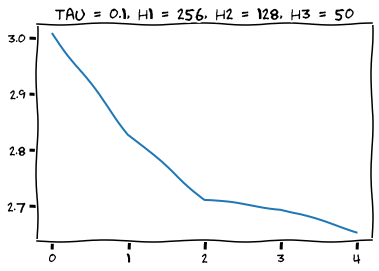

In [ ]:
criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.SUM)
decay_steps = 1000
lr_decayed_fn = tf.keras.experimental.CosineDecay(initial_learning_rate=0.1, decay_steps=decay_steps)
optimizer = tf.keras.optimizers.SGD(lr_decayed_fn)

resnet_simclr_2 = get_resnet_simclr(256, 128, 50)

epoch_wise_loss, resnet_simclr = train_simclr(resnet_simclr_2, train_ds, optimizer, criterion, temperature=0.1, epochs=5, log_interval=5)

with plt.xkcd():
    plt.plot(epoch_wise_loss)
    plt.title("tau = 0.1, h1 = 256, h2 = 128, h3 = 50")
    plt.show()